# Multipulse measurement
This script is used to apply voltage pulses with varied pulsewidth and capture the device response at the oscilloscope

In [27]:
import numpy as np
x = np.linspace(1,10,10) # array of values from 1 to 10 with 10 evenly spaced parts
y = np.arange(1,10,1) # array of values between 1 to <10 with a step size of 1
print (x)
print (y)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[1 2 3 4 5 6 7 8 9]


#### Import library files and list instruments connected to the resource manager

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyvisa
from datetime import datetime
from scr import *
import glob

In [ ]:
rm = pyvisa.ResourceManager()
print(rm.list_resources()) # list connected instruments

#### Open a connection with resource manager

In [2]:
#pulsegen = rm.open_resource("TCPIP0::192.168.0.126::inst0::INSTR") #Agilent
pulsegen = rm.open_resource("GPIB0::10::INSTR") #HP
scope = rm.open_resource("TCPIP0::192.168.0.5::inst0::INSTR")
print(pulsegen.query("*IDN?"))
print(scope.query("*IDN?"))

HEWLETT-PACKARD,HP81110A,DE38700131,REV 01.12.03

AGILENT TECHNOLOGIES,DSO-X 3034A,MY53160262,02.43.2018020635



#### Initialize the instruments

In [33]:
# ======== initialize pulse generator ====================
pulsegen.write("*RST")
pulsegen.write(":DISPlay On")
pulsegen.write(":HOLD VOLT") # enable voltage or current subsystem
pulsegen.write(":FUNC1 PULse") # for Agilent 81160
pulsegen.write(":ROSC:SOUR Int")  # external reference clock
pulsegen.write(":OUTP1:IMP 50OHM")  # set OUT1 source impedance
pulsegen.write(":OUTP1:IMP:EXT 50OHM")  # or 1MOHM 
pulsegen.write(":OUTP1:POL NORM")   # set OUT1 polarity
pulsegen.write(":CHAN:MATH OFF")  # channel math off
pulsegen.write(":TRIG:COUN 1")
pulsegen.write(":ARM:SOUR MAN")
#pulsegen.write("*WAI")
# ======== initialize Oscilloscope =======================
scope.write("*CLS")
scope.write("*RST")
#--Channel 1 settings ----
scope.write("CHAN1:DISP OFF")  # enable channel 1 trace
scope.write("CHAN1:COUP DC")  # channel 1 coupling
scope.write("CHAN1:BWL OFF") # set channel 1 bandwidth to full bandwidth of oscilloscope
scope.write("CHAN1:IMP FIFT") # or ONEMeg
scope.write("CHAN1:SCAL 1")  # set channel 1 vertical scale
scope.write("CHAN1:OFFS 0")  # set channel 1 offset
#--Channel 2 settings ----
scope.write("CHAN2:DISP ON")  
scope.write("CHAN2:COUP DC")  
scope.write("CHAN2:BWL OFF") 
scope.write("CHAN2:IMP FIFT") #FIFT, 1Meg
scope.write("CHAN2:SCAL 1")  
scope.write("CHAN2:OFFS 0")  
#--- time settings ------
scope.write(":TIMebase:SCALe 1")
scope.write(":TIMebase:POSition 0")
#---trigger settings -----
scope.write("TRIG:SOUR EXT") # Externally triggered from pulse generator
scope.write("TRIG:MODE EDGE") # Edge triggered
scope.write("TRIG:SLOP POS") # Triggered on positive slope

15

#### Define the functions for apply pulse, measure and aquire data

In [34]:
#======= apply a pulse =========================
def apply_pulse(ep):
    pulsegen.write(f":VOLT1 {ep.amplitude}V")
    pulsegen.write(f":VOLT1:OFFS {ep.amplitude/2}V") # set offset = amplitude/2
    pulsegen.write(f":FUNC1 PULse")
    pulsegen.write(f":FUNC1:PULS:WIDT {ep.pulsewidth}NS")
    pulsegen.write(f":FUNC1:PULS:TRAN {ep.risetime}NS") # leading edge transition time
    pulsegen.write(f":FUNC1:PULS:TRAN:TRA:AUTO OFF") # trailing edge = leading edge OFF
    pulsegen.write(f":FUNC1:PULS:TRAN:TRA {ep.falltime}NS") # trailing edge transition time
    pulsegen.write(f":TRIG:COUN 1")
#============ apply a burst of pulses with burst_count =============
def apply_burst(ep,burst_count):
    pulsegen.write(f":VOLT1 {ep.amplitude}V")
    pulsegen.write(f":VOLT1:OFFS {ep.amplitude/2}V") 
    pulsegen.write(f":FUNC1 PULse")
    pulsegen.write(f":FUNC1:PULS:WIDT {ep.pulsewidth}NS")
    pulsegen.write(f":FUNC1:PULS:TRAN {ep.risetime}NS") 
    pulsegen.write(f":FUNC1:PULS:TRAN:TRA:AUTO OFF") 
    pulsegen.write(f":FUNC1:PULS:TRAN:TRA {ep.falltime}NS") 
    pulsegen.write(f":TRIG:COUN {burst_count}")
    pulsegen.write(":BURS1:MODE TRIG")
    #pulsegen.write(":BURS:INT:PER 200NS")
    pulsegen.write(":BURS1:STATe ON")
    #pulsegen.write(f":BURS1:NCYCles 2")
#============ measure the response at DSO =============================
def measure_scope(ep,Rs):
    #scope.write(f"CHAN2:SCAL {ep.amplitude/4  }")
    #scope.write(f"CHAN2:OFFS {ep.amplitude/4 *2}")
    Vout = ep.amplitude * (50/ (50 + Rs))
    scope.write(f"CHAN2:SCAL {Vout/4}")
    scope.write(f"CHAN2:OFFS {Vout/2}")
    pulseLength = (ep.pulsewidth + ep.risetime + ep.falltime) * 1e-9
    scope.write(f"TIM:SCAL {pulseLength/4}")
    #scope.write(f"TIM:POS {0}")
    scope.write(f"TIM:POS {pulseLength}")
    scope.write(":ACQUIRE:TYPE HRES")
    scope.write(":SINGLE") # Acquire a single trigger of data
# ====== Trigger the pulse =====================
def trigger_pulse():
    pulsegen.write(":OUTP1 ON")  # Turn on OUT1
    sleep(0.5)
    pulsegen.write("*TRG")
    sleep(1)
    pulsegen.write(":OUTP1 OFF")  # Turn off OUT1
# ========= Aquire data =======================
def aquire_data():
    waveform = WaveForm()
    # store all this information into a waveform structure for later use
    #scope.write(f":WAVEFORM:SOURCE CHAN1")
    # Get the data back as a WORD(i.e., INT16), other options are ASCII and BYTE
    #scope.write(":WAVEFORM:FORMAT WORD")
    # Set the byte order on the instrument as well
    #scope.write(":WAVEFORM:BYTEORDER LSBFirst")
    # Get the preamble block
    #preambleBlock = scope.query(":WAVeform:PREamble?")
    #rawData = scope.query_binary_values(":WAV:DATA?", "H")
    #waveform.addChannel(1, preambleBlock.split(","), rawData)
    scope.write(f":WAVEFORM:SOURCE CHAN2")
    scope.write(":WAVEFORM:FORMAT WORD")
    scope.write(":WAVEFORM:BYTEORDER LSBFirst")
    preambleBlock = scope.query(":WAVeform:PREamble?")
    rawData = scope.query_binary_values(":WAV:DATA?", "H")
    waveform.addChannel(2, preambleBlock.split(","), rawData)

### Set pulse parameters and execute the code

In [37]:
ep = PulseParameters(
    amplitude=10,  # V
    pulsewidth=100,  # ns
    risetime=2,  # ns
    falltime=2,  # ns
)
Rs = 350
apply_pulse(ep)
measure_scope(ep,Rs)
trigger_pulse()

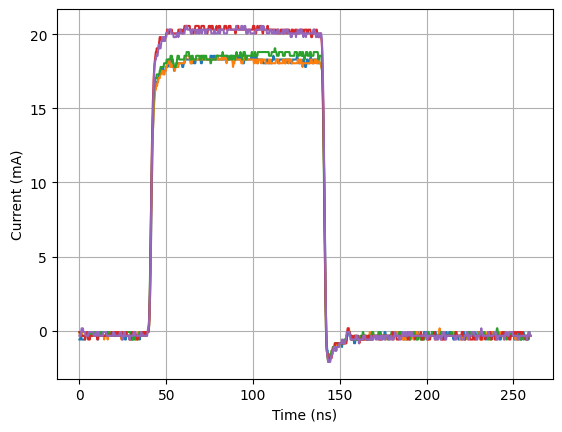

In [38]:
# ===== if burst pulses to be measured =======
def measure_scope_burst(ep,Rs,burst_count):
    #scope.write(f"CHAN2:SCAL {ep.amplitude/4  }")
    #scope.write(f"CHAN2:OFFS {ep.amplitude/4 *2}")
    Vout = ep.amplitude * (50/ (50 + Rs))
    scope.write(f"CHAN2:SCAL {Vout / 4}")
    scope.write(f"CHAN2:OFFS {Vout / 2}")
    pulseLength = (ep.pulsewidth + ep.risetime + ep.falltime) * 1e-9
    scope.write(f"TIM:SCAL {burst_count*1e-6/5}")
    #scope.write(f"TIM:POS -500NS")
    scope.write(f"TIM:POS {burst_count*1e-6*10/5/4-500*1e-9}")
    scope.write(":ACQUIRE:TYPE HRES")
    scope.write(":SINGLE") # Acquire a single trigger of data
#============== Plot channel 2 voltages with respect to time================
plt.figure()
plt.xlabel("Time (ns)")
plt.ylabel("Current (mA)")
plt.grid(which='both')
#======== set pulse parameters here ============================
ep = PulseParameters(
    amplitude=10,  # V
    pulsewidth=100,  # ns
    risetime=2,  # ns
    falltime=2,  # ns
)
Rs = 350
#burst_count_max = 65536
#---- for burst_count = 10, 100, 1000, 10000 -----------------
for i in range (4):
    burst_count = 10**(i+1)
    # apply burst of pulses without aquiring data
    apply_burst(ep,burst_count)
    measure_scope_burst(ep,Rs,burst_count)
    trigger_pulse()
    #aquire_data()        
    #waveform = WaveForm()
    #plt.plot(waveform.time(2) * 1e9, waveform.ch(2)*1000/50) 
    #np.savez_compressed(f"{burst_count}", **waveform.asdict()) #save multiple arrays
    pulsegen.write(":BURS1:STATe OFF")
    # Measure the response with single pulse
    apply_pulse(ep)
    measure_scope(ep,Rs)
    trigger_pulse()
    aquire_data()        
    waveform = WaveForm()
    plt.plot(waveform.time(2) * 1e9, waveform.ch(2)*1000/50) 
    # Save the measurement
    sp = SampleParameters('d06_10V_100ns_'+str(burst_count))
    np.savez_compressed(f"{sp.name}", **waveform.asdict()) #save multiple arrays
#---- for burst_count = 100000 -----------------
for i in range (2):
    burst_count = 50000
    apply_burst(ep,burst_count)
    measure_scope_burst(ep,Rs,burst_count)
    trigger_pulse()   
pulsegen.write(":BURS1:STATe OFF")
apply_pulse(ep)
measure_scope(ep,Rs)
trigger_pulse()
aquire_data()        
waveform = WaveForm()
plt.plot(waveform.time(2) * 1e9, waveform.ch(2)*1000/50) 
# Save the measurement
sp = SampleParameters('d06_10V_100ns_100000')
np.savez_compressed(f"{sp.name}", **waveform.asdict()) #save multiple arrays

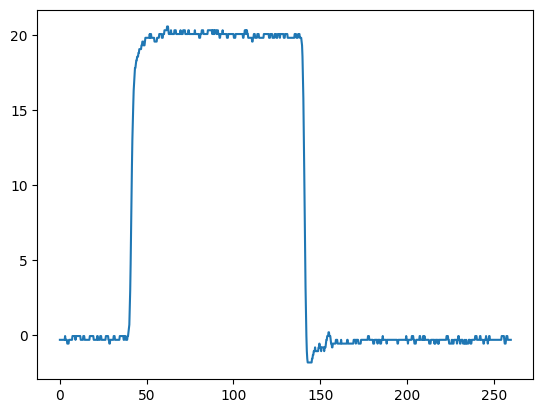

In [39]:
#---- for burst_count = 10**6 -----------------
for i in range (20):
    burst_count = 50000
    apply_burst(ep,burst_count)
    measure_scope_burst(ep,Rs,burst_count)
    trigger_pulse()   
pulsegen.write(":BURS1:STATe OFF")
apply_pulse(ep)
measure_scope(ep,Rs)
trigger_pulse()
aquire_data()        
waveform = WaveForm()
plt.plot(waveform.time(2) * 1e9, waveform.ch(2)*1000/50) 
# Save the measurement
sp = SampleParameters('d06_10V_100ns_1000000')
np.savez_compressed(f"{sp.name}", **waveform.asdict()) #save multiple arrays

#### Plot the measured data

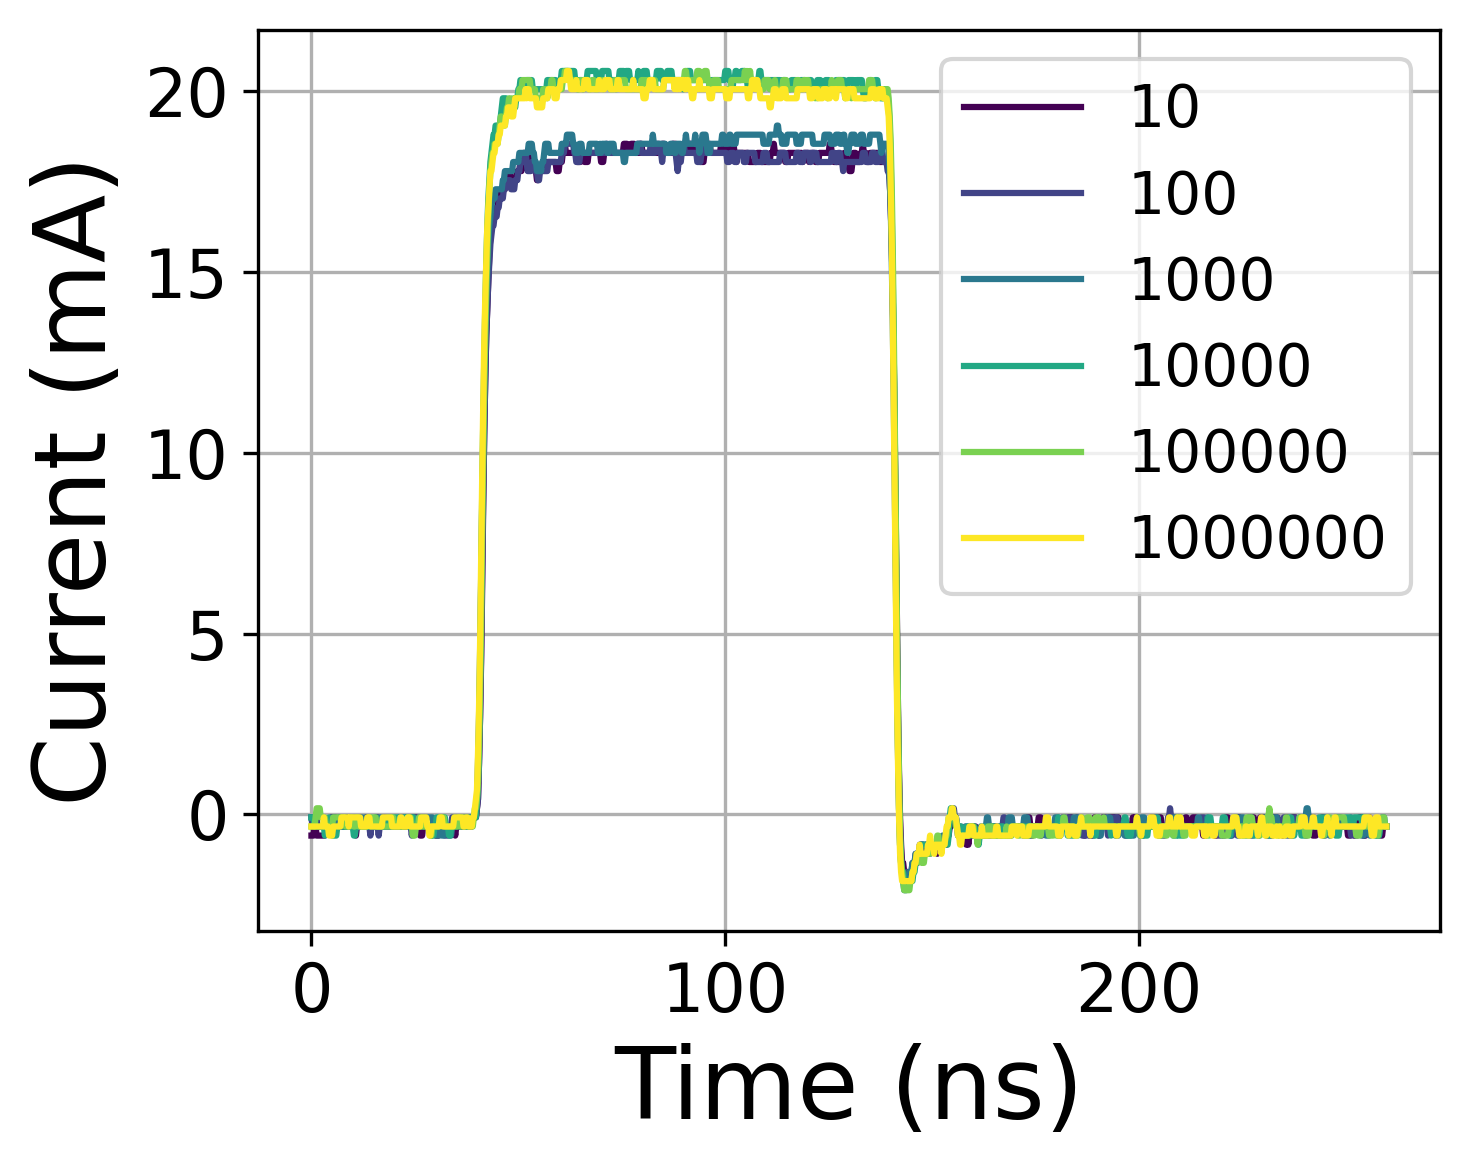

In [7]:
# ===== Figure settings ===============================
fig, axs = plt.subplots(figsize=(5, 4), dpi= 300, layout = 'tight')

# ====================================================
# ========= Figure a =================================
# ====================================================
axs.set_xlabel('Time (ns)', fontsize=12) 
axs.set_ylabel('Current (mA)',fontsize=12)
#axs[0].set_xscale("log"); 
#axs[0].set_ylim([-150, 0])
axs.tick_params(axis='both', which='major', labelsize=10)
axs.grid()
Current = []
n=6
colors = plt.cm.viridis(np.linspace(0, 1, n)) # using color map for plot
for i in range (n):
    burst_count = 10**(i+1)
    data = np.load('d06_10V_100ns_'+str(burst_count)+'.npz')
    axs.plot(data['time2'] * 1e9, data['ch2']*1000/50, color=colors[i], label=str(burst_count))
    #Imax = np.max(data['ch2'])*1000/50 #mA
    #Current.append(Imax)
    #i += 1
    
axs.legend(fontsize="8", loc="best")
#print(Current)
#plt.savefig('after_10V_burst_count_pulses4.jpg')
